In [26]:
#import nltk
#from nltk.grammar import CFG, Production
from nltk import CFG, Production, Nonterminal
from hazm import word_tokenize
from hazm import POSTagger
from nltk import ChartParser
from nltk.tree import Tree
import matplotlib.pyplot as plt
from langdetect import detect

In [27]:
tagger = POSTagger(model='pos_tagger.model')

FileNotFoundError: [Errno 2] No such file or directory: 'pos_tagger.model'

In [57]:
# sentence = "من امروز مشغول این کار هستم و فردا دوباره باید در آن منطقه بیدار شوم"
# sentence = "من امروز مشغول این کار هستم"
# sentence = 'کار خوب است'
# sentence = 'آن کیف جدید تو را میبرم'
sentence = 'من و تو و احمد به خانه دوست او رفتیم برای آنکه یک چایی بخوریم'
# sentence = 'این آمار نشان میدهد که ۸۲ تا ۸۳ درصد مردم به «فارسی» سخن میگویند.'

In [58]:
def parse_sentence(sentence):
    try:
        # Проверяем язык текста
        lang = detect(sentence)
        if lang != 'fa':
            return "Пожалуйста, введите предложение на персидском языке."
        
        tagged_s = tagger.tag(word_tokenize(sentence))
        
        return tagged_s
    except:
        return "Не удалось распознать язык предложения."

tagged_s = parse_sentence(sentence)

In [ ]:
tagged_s = tagger.tag(word_tokenize(sentence))
tagged_s

[('این', 'DET'),
 ('آمار', 'NOUN'),
 ('نشان', 'NOUN'),
 ('میدهد', 'VERB'),
 ('که', 'SCONJ'),
 ('۸۲', 'NUM'),
 ('تا', 'ADP'),
 ('۸۳', 'NUM'),
 ('درصد', 'NOUN,EZ'),
 ('مردم', 'NOUN'),
 ('به', 'ADP'),
 ('«', 'PUNCT'),
 ('فارسی', 'NOUN'),
 ('»', 'PUNCT'),
 ('سخن', 'NOUN'),
 ('میگویند', 'VERB'),
 ('.', 'PUNCT')]

In [60]:
base_grammar = CFG.fromstring("""
    FulS -> S PUNCT | S
    S -> NP VP | VP | VP CP | VP SConjP
    SConjP -> SCONJ VP
    CP -> CONJ NP | CONJ VP
    CompV -> N V | ADJ V
    NP_ez -> N_ez NP | N_ez AdjP | N_ez NP_ez | NP_ez PRO
    ProP -> PRO NP | PRO NP_ez
    NP -> N | N_ez | N NP | N AdjP | NP CONJ NP | N AdjP | NP N | NP PRO | PRO NP | NUM NP | ProP CONJ NP | NP CONJ ProP | PUNCT N PUNCT | PUNCT NP PUNCT
    VP -> NP V | AdjP V | ADV VP | N VP | PP V | PP VP | PostP V | ProP VP | V | V VP | DetP VP
    ProP -> PRO | PRO CONJ PRO
    DemP -> DEM NP
    AdjP -> ADJ | ADJ_ez | ADJ_ez AdjP | ADJ_ez DetP | ADJ_ez NP | ADJ_ez ProP
    DetP -> DET NP | DetP ADJ
    PP -> P NP | P NP_ez | P DetP | P CONJ | PP VP | NUM PP | P NUM
    PostP -> NP P | ProP P
""")

In [61]:
def update_grammar_with_pos_tags(base_grammar, tagged_s):
    # Собираем множества слов для каждой части речи
    nouns = set()
    nouns_ez = set()
    pronouns = set()
    verbs = set()
    adjectives = set()
    adjectives_ez = set()
    adverbs = set()
    demonstratives = set()
    determinatives = set()
    prepositions = set()
    conjunctions = set()
    sconjunctions = set()
    punctuation = set()
    numer = set()
    for word, tag in tagged_s:
        if tag == 'NOUN':
            nouns.add(word)
        elif tag == 'NOUN,EZ':
            nouns_ez.add(word)
        elif tag.startswith('V'):
            verbs.add(word)
        elif tag == 'ADJ':
            adjectives.add(word)
        elif tag == 'ADJ,EZ':
            adjectives_ez.add(word)
        elif tag == 'DEM':
            demonstratives.add(word)
        elif tag == 'DET':
            determinatives.add(word)
        elif tag == 'ADP' or tag == 'ADP,EZ':
            prepositions.add(word)
        elif tag == 'CCONJ':
            conjunctions.add(word)
        elif tag == 'SCONJ':
            sconjunctions.add(word)
        elif tag == 'PRON':
            pronouns.add(word)
        elif tag == 'NUM':
            numer.add(word)
        elif tag == 'ADV':
            adverbs.add(word)
        elif tag == 'PUNCT':
            punctuation.add(word)

    
    # Создаем список правил для обновления грамматики
    new_productions = []
    for noun in nouns:
        new_productions.append(Production('N', [noun]))
    for noun_ez in nouns_ez:
        new_productions.append(Production('N_ez', [noun_ez]))
    for pronoun in pronouns:
        new_productions.append(Production('PRO', [pronoun]))
    for verb in verbs:
        new_productions.append(Production('V', [verb]))
    for adj in adjectives:
        new_productions.append(Production('ADJ', [adj]))
    for adj_ez in adjectives_ez:
        new_productions.append(Production('ADJ_ez', [adj_ez]))
    for num in numer:
        new_productions.append(Production('NUM', [num]))
    for adv in adverbs:
        new_productions.append(Production('ADV', [adv]))
    for conj in conjunctions:
        new_productions.append(Production('CONJ', [conj]))
    for sconj in sconjunctions:
        new_productions.append(Production('SCONJ', [sconj]))
    for dem in demonstratives:
        new_productions.append(Production('DEM', [dem]))
    for det in determinatives:
        new_productions.append(Production('DET', [det]))
    for prep in prepositions:
        new_productions.append(Production('P', [prep]))
    for punct in punctuation:
        new_productions.append(Production('PUNCT', [punct]))
    
    # Создаем новый объект CFG с объединенными правилами
    updated_grammar = CFG(base_grammar.start(), base_grammar.productions() + new_productions)
    
    return updated_grammar

# Обновляем грамматику с учетом предложения и его частей речи
grammar = update_grammar_with_pos_tags(base_grammar, tagged_s)

# Теперь мы можем использовать эту грамматику для синтаксического анализа предложений на персидском языке.


In [62]:
print(grammar)

Grammar with 65 productions (start state = FulS)
    FulS -> S PUNCT
    FulS -> S
    S -> NP VP
    S -> VP
    S -> VP CP
    S -> VP SConjP
    SConjP -> SCONJ VP
    CP -> CONJ NP
    CP -> CONJ VP
    CompV -> N V
    CompV -> ADJ V
    NP_ez -> N_ez NP
    NP_ez -> N_ez AdjP
    NP_ez -> N_ez NP_ez
    NP_ez -> NP_ez PRO
    ProP -> PRO NP
    ProP -> PRO NP_ez
    NP -> N
    NP -> N_ez
    NP -> N NP
    NP -> N AdjP
    NP -> NP CONJ NP
    NP -> N AdjP
    NP -> NP N
    NP -> NP PRO
    NP -> PRO NP
    NP -> NUM NP
    NP -> ProP CONJ NP
    NP -> NP CONJ ProP
    NP -> PUNCT N PUNCT
    NP -> PUNCT NP PUNCT
    VP -> NP V
    VP -> AdjP V
    VP -> ADV VP
    VP -> N VP
    VP -> PP V
    VP -> PP VP
    VP -> PostP V
    VP -> ProP VP
    VP -> V
    VP -> V VP
    VP -> DetP VP
    ProP -> PRO
    ProP -> PRO CONJ PRO
    DemP -> DEM NP
    AdjP -> ADJ
    AdjP -> ADJ_ez
    AdjP -> ADJ_ez AdjP
    AdjP -> ADJ_ez DetP
    AdjP -> ADJ_ez NP
    AdjP -> ADJ_ez ProP
    De

In [63]:
words_and_phrases = {}

for production in grammar.productions():
    nonterminal = production.lhs()  # Левая сторона продукции
    if isinstance(production.rhs()[0], str):  # Проверяем, что первый символ является строкой (терминалом)
        if nonterminal not in words_and_phrases:
            words_and_phrases[nonterminal] = []  # Создаем список для данного нетерминала
        words_and_phrases[nonterminal].append(production.rhs()[0])

print(words_and_phrases)


{'N_ez': ['کار'], 'V': ['است'], 'ADJ': ['خوب']}


In [64]:
# Обновляем грамматику с учетом слов и фраз
productions = list(base_grammar.productions())
for nonterminal, words_list in words_and_phrases.items():
    for word in words_list:
        productions.append(Production(Nonterminal(nonterminal), [word]))

updated_grammar = CFG(base_grammar.start(), productions)

print(updated_grammar)


Grammar with 65 productions (start state = FulS)
    FulS -> S PUNCT
    FulS -> S
    S -> NP VP
    S -> VP
    S -> VP CP
    S -> VP SConjP
    SConjP -> SCONJ VP
    CP -> CONJ NP
    CP -> CONJ VP
    CompV -> N V
    CompV -> ADJ V
    NP_ez -> N_ez NP
    NP_ez -> N_ez AdjP
    NP_ez -> N_ez NP_ez
    NP_ez -> NP_ez PRO
    ProP -> PRO NP
    ProP -> PRO NP_ez
    NP -> N
    NP -> N_ez
    NP -> N NP
    NP -> N AdjP
    NP -> NP CONJ NP
    NP -> N AdjP
    NP -> NP N
    NP -> NP PRO
    NP -> PRO NP
    NP -> NUM NP
    NP -> ProP CONJ NP
    NP -> NP CONJ ProP
    NP -> PUNCT N PUNCT
    NP -> PUNCT NP PUNCT
    VP -> NP V
    VP -> AdjP V
    VP -> ADV VP
    VP -> N VP
    VP -> PP V
    VP -> PP VP
    VP -> PostP V
    VP -> ProP VP
    VP -> V
    VP -> V VP
    VP -> DetP VP
    ProP -> PRO
    ProP -> PRO CONJ PRO
    DemP -> DEM NP
    AdjP -> ADJ
    AdjP -> ADJ_ez
    AdjP -> ADJ_ez AdjP
    AdjP -> ADJ_ez DetP
    AdjP -> ADJ_ez NP
    AdjP -> ADJ_ez ProP
    De

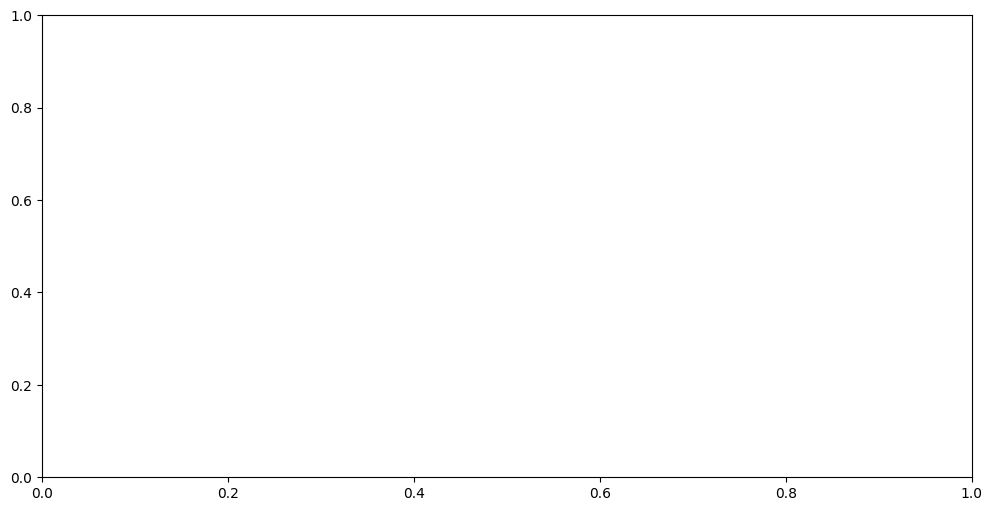

In [65]:
parser = ChartParser(updated_grammar)
for tree in parser.parse(word_tokenize(sentence)):
    fig, ax = plt.subplots(figsize=(12, 6))
    tree.draw()
    plt.show()
    break


In [43]:
from lab2_lab3 import get_the_tree

In [44]:
get_the_tree(sentence)